# DEEP LEARNING PARA EL ANÁLISIS DE IMÁGENES

# PARTE 2: Aplicación CNN, Reconocimiento de expresiones faciales 

Machine Learning - Master en Data Science CUNEF

Gerardo Ramis y Álvaro Rodríguez

## 1) Objetivos

Este documento pretende servir de aplicación de los conceptos expuestos en la parte 1, aplicando modelos con más capas sobre datasets más complejos.

## 2) Datos

Los datos consisten en imágenes en escala de grises de 48x48 píxeles de caras. Las caras se han registrado automáticamente para que la cara esté más o menos centrada y ocupe aproximadamente la misma cantidad de espacio en cada imagen. La tarea es categorizar cada rostro según la emoción mostrada en la expresión facial en una de las siete categorías (0 = Cabreo, 1 = Disgusto, 2 = Miedo, 3 = Felicidad, 4 = Tristeza, 5 = Sorpresa, 6 = Neutral).

train.csv contiene dos columnas, "emoción" y "píxeles". La columna "emoción" contiene un código numérico que va de 0 a 6, inclusive, para la emoción que está presente en la imagen. La columna "píxeles" contiene una cadena rodeada de comillas para cada imagen. El contenido de esta cadena es un valor de píxeles separados por espacios en el orden mayor de la fila. test.csv contiene solo la columna "píxeles" y su tarea es predecir la columna de emoción.

El conjunto de entrenamiento consta de 28.709 ejemplos. El conjunto de pruebas públicas utilizado para la tabla de clasificación consta de 3.589 ejemplos.

Este conjunto de datos fue preparado por Pierre-Luc Carrier y Aaron Courville, como parte de un proyecto de investigación y conforme a tales datos se creó una competición en Kaggle.

#### a) Paquetes 

In [41]:
from __future__ import print_function
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense , Activation , Dropout ,Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.metrics import categorical_accuracy
from tensorflow.python.keras.models import model_from_json
from sklearn.model_selection import train_test_split


from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


#### b) Importación de datos

In [4]:
# Importamos la información

ruta = 'fer2013/fer2013.csv'
emociones = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def importardatos(ruta):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(ruta):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


X, Y = importardatos(ruta)
num_class = len(set(Y))


In [5]:
# Muestra de entrenamiento
X.shape


(35887, 2304)

In [6]:
# Muestra de Test
Y.shape

(35887,)

#### c) Muestras de entrenamiento, validación y test

In [10]:
# keras con backend tensorflow
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

# dividimos en set de entrenamiento, validación y test. Proporciones 80:10:10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

#### d) Análisis exploratorio de los datos


- Balanceo de la muestra

In [7]:

# Vemos el numero de muestra de entrenamiento por cada emoción
def balance_clases(Y):
    num_class = set(Y)
    count_class = {}
    for i in range(len(num_class)):
        count_class[i] = sum([1 for y in Y if y == i])
    return count_class

balance = balance_clases(Y)


In [8]:
# La caras de disgusto son escasas en comparación con el resto
balance

{0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6077, 5: 4002, 6: 6198}

- Imagenes contenidas en el dataset

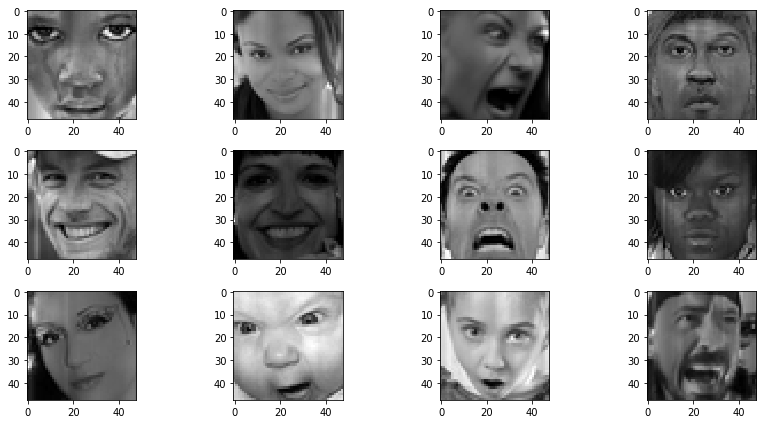

In [11]:
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
   plt.subplot(3,4,i)
   plt.imshow(X_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

## 3) PROCEDIMIENTO

La estructura de la CNN planteada en este notebook es la siguiente:

 - **(Convolución & Pooling) x 4** 
 
 - **Flatten** 
 
 - **Red densamente conectada x 2** 
 
 - **Resultado**

El modelo está compuesto por cuatro capas convolucionales, una capa de aplanado y, finalmente, dos capas Fully Connected.

## 4) MODELO

### A) Convolución

Para este modelo se ha configurado la capa Convnet inicial para procesar entradas de tamaño (48, 48, 1) a travel del argumento input_shape. 48x48 indica la dimensión de la imagen en pixeles mientras que el número uno corresponde al color, escala de grises.

Recordamos que las capas convolucionales se definen en base a dos parametros: El de los parches extraidos y la cantidad de filtros calculados por convolción. Los parámetros dados a este modelo, compuesto de 4 convolutional layers son (filtros, tamaño parche):

 - Primera capa: (64, 3x3)
 - Segunda capa: (128, 5x5)
 - Tercera capa: (512, 3x3)
 - Cuarta capa: (512, 3x3)
 
**Relu** ha sido La función de activación no lineal usada en cada una de las capa convolucionales.

### B) Pooling (reducción)

Para este modelo se han añadido, a cada una de las capas convolucionales, cuatro submuestreos maxp-pooling de ventanas 2x2 con el objetivo de reducir la muestras de los mapas de características.

El resultado es que para cada una de las capas de convolucionales, los inputs de entrada han sido reducidos a la mitad:

 - Primera capa: input_shape(48x48x1), conv2D(48x48x64), **max-pooling(2x2)** la transforma a **(24x24x64)** que será la que reciba la siguiente capa. 
 - Segunda capa: input_shape(24x24x64), conv2D(24x24x128), **max-pooling(2x2)** la transforma a **(12x12x64)**.
 - Tercera capa: input_shape(12x12x64), conv2D(12x12x512), **max-pooling(2x2)** la transforma a **(6x6x512)**.
 - Cuarta capa: input_shape(6x6x512), conv2D(6x6x512), **max-pooling(2x2)** la transforma a **(3x3x512)**.

### C) Red Densamente Conectada

Este modelo, como hemos señalado anteriormente, consta de **dos capas densamente conectadas (Dense)**. En este tipo de capas, todos los nodos estás completamente conectados. 

Se lleva a cabo un proceso de unidimensionalidad de los tensores mediante la función **Flatten**. Este paso es fundamental para poder trabajar con las capas dense. Los tensores devuetos tras la última capa convolucional tienen dimensiones de 3x3x512 y, tras el aplanado con Flatten, pasan ser unidimensionales (1x4608).

Se aplica una primera capa Dense con 256 unidades y una segunda con 512 unidades. La función de activación utilizada es relu.

### D) Compilación

Se establece en este paso cómo optimizar el modelo. Se establecen 3 parámetros:

- Optimizador: **Adam** (Extensión del descenso de gradiente estocástico).
- Función de pérdida: **binary_crossentropy**.
- Metrics: **categorical_accuracy**.

### E) Arquitectura del modelo

In [37]:

batch_size = 128
epochs = 20

#Main CNN model with four Convolution layer & two fully connected layer
def baseline_model():
    # Initialising the CNN
    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,(5,5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_class, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[categorical_accuracy])
    return model


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 128)       512       
__________

### F) Aplicación del modelo

In [13]:
# Si estuviera salvado, recuperamos los pesos para evitar re-calcular.
def baseline_model_saved():
    #load json and create model
    json_file = open('model_4layer_2_2_pool.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights from h5 file
    model.load_weights("model_4layer_2_2_pool.h5")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[categorical_accuracy])
    return model

is_model_saved = True

In [39]:
# Si esta salvado, se calculan los pesos del modelo y se guardan en formato json
if(is_model_saved==False ):
    # Train model
    model = baseline_model()
    # Note : 3259 muestras como datos de validación &   28,709 como muestra de entrenamiento

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_split=0.1111)
    model_json = model.to_json()
    with open("model_4layer_2_2_pool.json", "w") as json_file:
        json_file.write(model_json)
    # pesos a formato jerárquico HDF5
    model.save_weights("model_4layer_2_2_pool.h5")
    print("Saved model to disk")
else:
    # carga del modelo si estuviera salvado
    print("Load model from disk")
    model = baseline_model_saved()


Train on 28709 samples, validate on 3589 samples
Epoch 1/20
 - 833s - loss: 0.3856 - categorical_accuracy: 0.3194 - val_loss: 0.4693 - val_categorical_accuracy: 0.2419
Epoch 2/20
 - 827s - loss: 0.3145 - categorical_accuracy: 0.4634 - val_loss: 0.3791 - val_categorical_accuracy: 0.3483
Epoch 3/20
 - 820s - loss: 0.2849 - categorical_accuracy: 0.5250 - val_loss: 0.3139 - val_categorical_accuracy: 0.4347
Epoch 4/20
 - 806s - loss: 0.2683 - categorical_accuracy: 0.5571 - val_loss: 0.2908 - val_categorical_accuracy: 0.5130
Epoch 5/20
 - 807s - loss: 0.2555 - categorical_accuracy: 0.5827 - val_loss: 0.2657 - val_categorical_accuracy: 0.5678
Epoch 6/20
 - 824s - loss: 0.2464 - categorical_accuracy: 0.5990 - val_loss: 0.2635 - val_categorical_accuracy: 0.5651
Epoch 7/20
 - 826s - loss: 0.2349 - categorical_accuracy: 0.6231 - val_loss: 0.2588 - val_categorical_accuracy: 0.5745
Epoch 8/20
 - 820s - loss: 0.2268 - categorical_accuracy: 0.6370 - val_loss: 0.2739 - val_categorical_accuracy: 0.5592

### G) Testing

Se procede, una vez entrenado el modelo, a evaluar cómo se comportan los datos de test. Comprobamos la eficacia de nuestro modelo. La precisión de nuestro modelo con los datos de test es de 57%. Es una precisión destacable habida cuenta de que las probabilidades de clasificar bien estas emociones aleatoriamente son de 14.29%.

In [52]:
# Modelo predice la probabilidad para cada uno de las 7 etiquetas por cada imagen de test.
score = model.predict(X_test)
print (model.summary())

new_X = [ np.argmax(item) for item in score ]
y_test2 = [ np.argmax(item) for item in y_test]

# Calculating categorical accuracy taking label having highest probability
accuracy = [ (x==y) for x,y in zip(new_X,y_test2) ]
print(" Accuracy on Test set : " , np.mean(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 128)       512       
__________

## 5) RESULTADOS

Vamos a comprabar imagenes aleatorias para poder comprobar si el modelo realiza la predicción correctamente. Cada vez que se ejecuta el siguiente chunk de código se puede comprobar una por una, las imágenes, su etiqueta real y el valor arrojado en predicción.

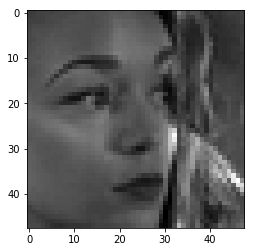

> testing image index: 1940
> true emotion: sad
> predicted emotion: sad


In [74]:

def get_emotion(ohv):
   if ohv.shape[0] == 1:
       indx = ohv[0]
   else:
       indx = np.argmax(ohv)
       
   if indx == 0:
       return 'angry'
   elif indx == 1:
       return 'disgust'
   elif indx == 2:
       return 'fear'
   elif indx == 3:
       return 'happy'
   elif indx == 4:
       return 'sad'
   elif indx == 5:
       return 'surprise'
   elif indx == 6:
       return 'neutral'


img_indx = np.uint32(np.random.rand()*(X_test.shape[0] - 1))
sample = X_test[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_test[img_indx, :]), get_emotion(pred_cls)))

## 5) REFERENCIAS

- "Adam: A Method for Stochastic Optimization". Cornell University.

- "Deep Learning with Python". François Chollet

- Challenges in Representation Learning: Facial Expression Recognition Challenge. Kaggle. 2013

- Keras: https://keras.io/

- TensorFlow: https://www.tensorflow.org/

- Introduction to Deep Learning: https://pythonprogramming.net/introduction-deep-learning-python-tensorflow-keras/